**Задача** <br>
 1. Найти или сгенерировать набор данных для бинарной классификации графов.
 2. Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test <br>
2.1. Опишите графы с помощью вектора из количества кратчайших путей различной длины <br>
2.2. Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G) <br>
2.3. Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов <br>
2.4. K_train - матрица из ядровых функций для сравнения тренировочных графов между собой<br>
2.5. K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными<br>
 3. Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
 4. (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [94]:
import numpy as np
import pandas as pd

import networkx as nx

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from collections import Counter

**Сделаем генератор графов**

In [106]:
# Создадим набор графов с метками классов.
# Из доступных в графогенераторе NetworkX графов
# Выберем звезду (star_graph) и колесо (wheel_graph)
# Звёзды обозначим меткой "1", колёса - меткой "0"

# чтобы было интересно, количество вершин в каждом графе
# задаётся случайным числом от 50 до 150

star_graphs = []
wheel_graphs = []
all_graphs = []
labels = []

for _ in range(100):
    star_graphs.append(nx.star_graph(np.random.randint(50, 151)))

for _ in range(100):
    wheel_graphs.append(nx.wheel_graph(np.random.randint(50, 151)))

all_graphs.extend(star_graphs)
all_graphs.extend(wheel_graphs)

for i in range(200):
    if i < 100:
        labels.append(1)
    else:
        labels.append(0)

**Проверим правильность работы графогенератора**

Метка класса:   1
Количество вершин:   146


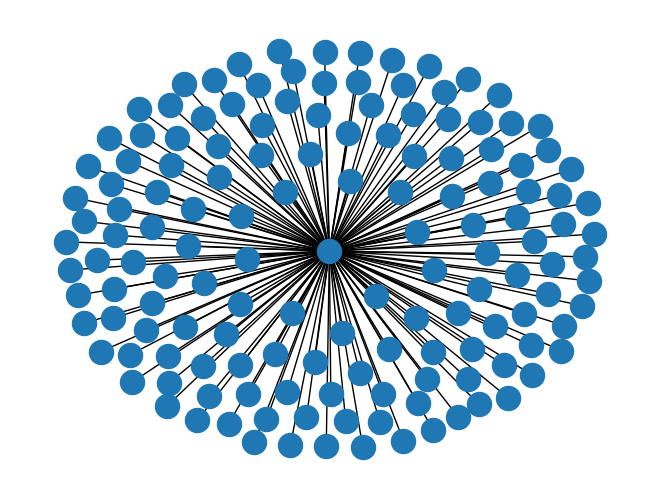

In [40]:
# Первые 100 элементов списка - это звёзды
# Выведем 10-й элемент

print('Метка класса:  ', labels[10])
print('Количество вершин:  ', len(all_graphs[10]))
nx.draw(all_graphs[10])

Метка класса:   0
Количество вершин:   75


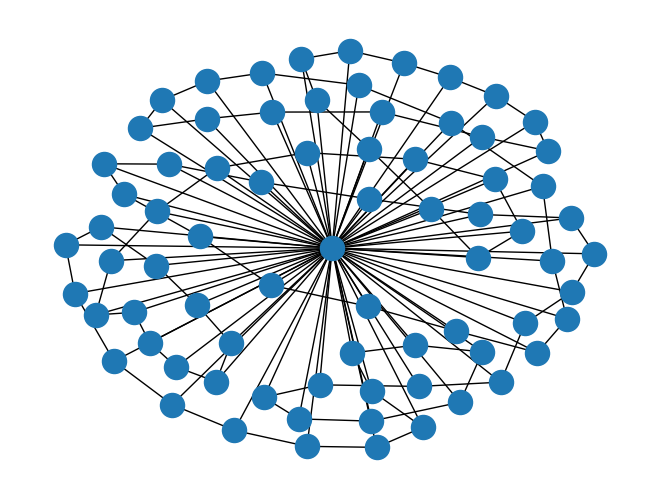

In [121]:
# Первые 100 элементов списка - это колёса
# Выведем 10-й элемент

print('Метка класса:  ', labels[120])
print('Количество вершин:  ', len(all_graphs[120]))
nx.draw(all_graphs[120])

**Разделим данные на тренировочную и тестовую часть**

In [107]:
train_graphs, test_graphs, y_train, y_test = train_test_split(all_graphs, labels, test_size=0.1, stratify=labels)

**Реализуем функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test**

In [108]:
def shortest_vector(graph_arr):
    # зададим количество узлов как максимально возможное количество
    # в каждой из групп графов (максимальное количество равно 150)

    max_nodes = 150

    # введём шаблоны для векторов кратчайших длин в виде нуль-графов
    # библиотеки нумпи
    result_arr = np.zeros((len(graph_arr), max_nodes * (max_nodes - 1)))

    # обходим граф в цикле и
    # составляем вектор кратчайших путей
    for i, graph in enumerate(graph_arr):
        cnt = 0
        #заполняем вектор кратчайших путей между каждой парой вершин
        for u in range(graph.number_of_nodes() - 1):
            for v in range(u + 1, graph.number_of_nodes()):
                result_arr[i][cnt] = nx.shortest_path_length(graph, u, v)
                cnt += 1

    return result_arr

In [109]:
# составим векторы кратчайших путей для двух наборов графов
train_shortest_arr = shortest_vector(train_graphs)
test_shortest_arr = shortest_vector(test_graphs)

In [110]:
# непосредственно функция shortest_path_kernel(train_graphs, test_graphs)

def shortest_path_kernel(train_shortest_arr, test_shortest_arr):

    # искомые матрицы вычисляются скалярным произведением

    K_train = np.dot(train_shortest_arr, train_shortest_arr.T)
    K_test = np.dot(test_shortest_arr, train_shortest_arr.T)
    return K_train, K_test



In [111]:
K_train_gk, K_test_gk = shortest_path_kernel(train_shortest_arr, test_shortest_arr)

**Выбор лучших гиперпараметров модели SVC**

In [102]:
parameters = {'cache_size': [100, 200, 300, 400, 500], 'C':[1, 3, 5, 7, 10], 'tol': [0.01, 0.001, 0.0001]}
model1 = SVC(kernel ='precomputed', random_state =42)
clf1 = GridSearchCV(model1, parameters)
clf1.fit(K_train_gk, y_train)
clf1.best_params_

{'C': 1, 'cache_size': 100, 'tol': 0.001}

**Обучение модели с выбранными параметрами**




In [113]:
best_model1 = SVC(C = 1, kernel ='precomputed', cache_size = 200, tol = 0.01)
best_model1.fit(K_train_gk, y_train)
y_pred1 = best_model1.predict(K_test_gk)

**Итоговые метрики**

In [114]:
print(f'Accuracy: {accuracy_score(y_test, y_pred1)}')
print(f'Precision: {round(precision_score(y_test, y_pred1), 2)}')
print(f'Recall: {recall_score(y_test, y_pred1)}')

Accuracy: 0.75
Precision: 0.78
Recall: 0.7


**Выводы**

1. По результатам обработки данных и работы модели получили довольно качественные результаты классификации

2. При большем количестве графов с большим количеством вершин можно получить более высокие показатели качества. (я проверял, сначала вообще мало вершин сделал, чтоб быстро работало)

**Дополнительное задание**

**Ядро Weisfeiler-Lehman**



In [67]:
# первый шаг - подготовка матриц для ядра Weisfeiler-Lehman

def Weisfeiler_Lehman_kernel_part_1(graph_arr):
    phi_arr = []
    iterations = 30

    for i, graph in enumerate(graph_arr):
        phi_dict = {1: graph.number_of_nodes()} # подготовка словаря для результирующего вектора
        hash = {'1': '1'} # сводная хэш-таблица (ключ - порядковый уникальный номер, значение - метка-индекс)
        node_vals = dict() # словарь (ключ - вершина, значение - текущая метка)
        for i in range(graph.number_of_nodes()):
            node_vals[i] = 1

        for f in range(iterations):
            #ограничиваю вектор определенным числом чисел (по 5 доп. ячеек на каждую итерацию)
            for o in range(f*10):
                phi_dict[o+2] = 0
            temp_hash = dict() #хэш-таблица очередной итерации алгоритма (ключ - вершина, значение - ее индекс)
            #в цикле для каждой вершины
            for j in range(graph.number_of_nodes()):
                temp_node_idx = str(node_vals[j]) + ',' #строка для конкатенации всех меток для вершины
                node_neighbs = '' #строка для меток всех соседей
                #выделяем соседей по матрице смежности
                temp_node_adj_matrix = nx.adjacency_matrix(graph)[:, [j]].toarray().reshape(-1)
                for k in range(len(temp_node_adj_matrix)):
                    #записываем метку каждого соседа
                    if temp_node_adj_matrix[k] == 1:
                        node_neighbs += str(node_vals[k])
                #строим итоговый индекс для вершины (ее метка + строка из меток соседей)
                temp_node_idx += ''.join(sorted(node_neighbs))
                temp_hash[j] = temp_node_idx
            #прохожусь по отсортированной хэш-таблице очередной итерации
            for j in {k: v for k,v in sorted(temp_hash.items(), key=lambda item: item[1])}.keys():
                #записываю очередное значение в сводную хэш-таблицу, если его там нет
                if temp_hash[j] not in hash.values():
                    max_iter = len(hash) #определяю максимальное значение в сводной хэш-таблице
                    hash[max_iter + 1] = temp_hash[j]
            for key, value in temp_hash.items():
                hash_item = list(filter(lambda x: hash[x] == value, hash))[0]
                #обновляю словарь с маркировкой узлов значением в сводной хэш-таблице
                node_vals[key] = hash_item
                #обновляю словарь для результирующего вектора
                if hash_item in phi_dict:
                    phi_dict[int(hash_item)] += 1

    sorted_dict = sorted(phi_dict.items())
    temp_phi = np.zeros(len(phi_dict.items()))
    for i in range(len(temp_phi)):
        temp_phi[i] = sorted_dict[i][1]
    phi_arr.append(temp_phi)


In [68]:
train_hash_list = Weisfeiler_Lehman_kernel_part_1(train_graphs)
test_hash_list = Weisfeiler_Lehman_kernel_part_1(test_graphs)

In [69]:
# перемножение матриц

def Weisfeiler_Lehman_kernel_part_2(train_arg, test_arg):
    K_train = np.dot(np.array(train_arg[:][:]), np.array(train_arg[:][:]).T)
    K_test = np.dot(np.array(test_arg[:][:]), np.array(train_arg[:][:]).T)
    return K_train, K_test

In [ ]:
K_train_gk2, K_test_gk2 = Weisfeiler_Lehman_kernel_part_2(train_hash_list, test_hash_list)

In [ ]:
# инициализация модели, обучение, предсказание
# парметры взяты из первой части работы

model2 = SVC(C = 1, kernel ='precomputed', cache_size = 200, tol = 0.01)
model2.fit(K_train_gk2, y_train)
y_pred2 = model2.predict(K_test_gk2)

In [117]:
# вывод метрик качества
print(f'Accuracy: {accuracy_score(y_test, y_pred2)}')
print(f'Precision: {precision_score(y_test, y_pred2)}')
print(f'Recall: {recall_score(y_test, y_pred2)}')

Accuracy:  0.77
Precision:  0.8
Recall: 0.7


**Выводы:**

1. С ядром Weisfeiler-Lehman время работы многократно увеличилось, поскольку используется многократный рекурсивный проход по вершинам.
2. Прибавка в точности (используемые метрики качества) весьма скромна. (на фоне многократно увеличившегося времени работы)
3. Так всё же точнее, при использовании функции Weisfeiler-Lehman модель обучения может более качественно различать графы и относить их к одному из классов.